# OSAS Transformer Model Evaluation

This notebook evaluates trained OSAS detection models (binary or multiclass) using comprehensive metrics and visualizations.

**Evaluation includes:**
- Accuracy, F1-score (macro), per-class recall
- Confusion matrix
- Classification report
- Predictions vs ground truth visualization

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Scikit-learn imports
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Project imports
from model import create_model, OSASTransformer
from dataset import OSASDataset, PatientAwareSplitter, create_data_loaders
from preprocess_data import OSASPreprocessor
from train_model import OSASTrainer

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Configuration and Data Loading

In [2]:
# Configuration
DATA_PATH = './data/processed_windows.pkl'
CHECKPOINTS_DIR = './checkpoints'
MODELS_DIR = os.path.join(CHECKPOINTS_DIR, 'models')
RESULTS_DIR = os.path.join(CHECKPOINTS_DIR, 'results')

# Evaluation parameters
TASK = 'multiclass'  # Change to 'binary', multiclass' or 'multitask' as needed
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")
print(f"Evaluating task: {TASK}")

Using device: cpu
Evaluating task: multiclass


In [3]:
# Load processed data
print("Loading processed data...")
try:
    windows, metadata = OSASPreprocessor.load_processed_data(DATA_PATH)
    print(f"Loaded {len(windows)} windows")
    print(f"Metadata keys: {list(metadata.keys()) if metadata else 'None'}")
except FileNotFoundError:
    print(f"Data file not found: {DATA_PATH}")
    print("Please run preprocess_data.py first to generate processed data.")
    raise

Loading processed data...
Loaded 31913 windows
Metadata keys: ['n_windows', 'window_size', 'overlap', 'filter_params', 'missing_threshold', 'patient_scalers']


In [4]:
# Create dataset and splits
print("Creating dataset and patient-aware splits...")
dataset = OSASDataset(windows, task=TASK)

# Split patients (same logic as training)
splitter = PatientAwareSplitter()
train_patients, val_patients, test_patients = splitter.split_patients(
    dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42
)

# Create split datasets
train_dataset, val_dataset, test_dataset = splitter.create_patient_datasets(
    dataset, train_patients, val_patients, test_patients
)

print(f"Dataset splits:")
print(f"  Train: {len(train_dataset)} windows from {len(train_patients)} patients")
print(f"  Val: {len(val_dataset)} windows from {len(val_patients)} patients")
print(f"  Test: {len(test_dataset)} windows from {len(test_patients)} patients")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=BATCH_SIZE, num_workers=0
)

Creating dataset and patient-aware splits...
Dataset validation: 31913 valid windows
Dataset statistics:
  Samples: 31913
  Patients: 30
  Label distribution: {'NONE': 28177, 'HYPOPNEA': 1926, 'APNEA-OBSTRUCTIVE': 1236, 'APNEA-MIXED': 429, 'APNEA-CENTRAL': 145}
  Feature shapes: {'vital_signs': (60, 5), 'waveforms': (60, 80, 4)}
Dataset validation: 22956 valid windows
Dataset statistics:
  Samples: 22956
  Patients: 21
  Label distribution: {'NONE': 20884, 'HYPOPNEA': 1306, 'APNEA-OBSTRUCTIVE': 651, 'APNEA-CENTRAL': 17, 'APNEA-MIXED': 98}
  Feature shapes: {'vital_signs': (60, 5), 'waveforms': (60, 80, 4)}
Dataset validation: 4131 valid windows
Dataset statistics:
  Samples: 4131
  Patients: 4
  Label distribution: {'NONE': 3652, 'HYPOPNEA': 330, 'APNEA-OBSTRUCTIVE': 125, 'APNEA-MIXED': 20, 'APNEA-CENTRAL': 4}
  Feature shapes: {'vital_signs': (60, 5), 'waveforms': (60, 80, 4)}
Dataset validation: 4826 valid windows
Dataset statistics:
  Samples: 4826
  Patients: 5
  Label distribution

## Model Configuration and Loading

In [5]:
# Check for existing training results to get configuration
results_filename = f'training_results_{TASK}.json'
results_path = os.path.join(RESULTS_DIR, results_filename)

if os.path.exists(results_path):
    print(f"Loading training results from: {results_path}")
    with open(results_path, 'r') as f:
        training_results = json.load(f)
    
    # Extract configuration
    config = training_results.get('config', {})
    print(f"Best epoch: {training_results.get('best_epoch', 'N/A')}")
    print(f"Best metric: {training_results.get('best_metric', 'N/A'):.4f}")
else:
    print(f"No training results found for {TASK} task")
    # Create default configuration
    config = {
        'task': TASK,
        'vital_dim': 5,
        'waveform_channels': 4,
        'waveform_length': 80,
        'psg_channels': 5,
        'psg_lengths': [20, 10, 10, 10, 10],
        'd_model': 256,
        'nhead': 8,
        'num_encoder_layers': 6,
        'dropout': 0.1,
        'num_classes': 2 if TASK == 'binary' else 5,
        'batch_size': BATCH_SIZE,
        'learning_rate': 1e-4,
        'weight_decay': 0.01,
        'optimizer': 'adamw',
        'device': DEVICE
    }
    print("Using default configuration")

# Update config with data-derived parameters
sample_features, _ = test_dataset[0]
if 'vital_signs' in sample_features:
    config['vital_dim'] = sample_features['vital_signs'].shape[-1]
if 'waveforms' in sample_features:
    config['waveform_channels'] = sample_features['waveforms'].shape[-1]
    config['waveform_length'] = sample_features['waveforms'].shape[1]

print(f"\nModel configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Loading training results from: ./checkpoints/results/training_results_multiclass.json
Best epoch: 19
Best metric: 0.2942

Model configuration:
  data_path: ./data/processed_windows.pkl
  task: multiclass
  d_model: 256
  nhead: 8
  num_encoder_layers: 6
  dropout: 0.1
  epochs: 50
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 0.01
  optimizer: adamw
  save_dir: ./checkpoints
  device: auto
  use_wandb: False
  experiment_name: None
  vital_dim: 5
  waveform_channels: 4
  waveform_length: 80
  num_classes: 5


In [6]:
# Load or create model
model_filename = f'best_model_{TASK}.pth'
model_path = os.path.join(MODELS_DIR, model_filename)

# Create model
model = create_model(config)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nCreated model with {total_params:,} total parameters ({trainable_params:,} trainable)")

# Try to load checkpoint
if os.path.exists(model_path):
    print(f"Loading model checkpoint from: {model_path}")
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Checkpoint best metric: {checkpoint.get('best_metric', 'unknown')}")
    model_loaded = True
else:
    print(f"\nNo model checkpoint found at: {model_path}")
    print("\nWARNING: No trained model found!")
    print("Options:")
    print("1. Train a new model using train_model.py")
    print("2. Use random weights for demonstration (not recommended for real evaluation)")
    
    use_random = input("\nUse random weights for demonstration? (y/n): ").lower().strip()
    if use_random == 'y':
        print("Using random weights - results will not be meaningful!")
        model_loaded = False
    else:
        print("Please train a model first using train_model.py")
        raise FileNotFoundError(f"Model checkpoint not found: {model_path}")

model.to(DEVICE)
model.eval()
print(f"Model moved to {DEVICE} and set to evaluation mode")


Created model with 5,025,636 total parameters (5,025,636 trainable)
Loading model checkpoint from: ./checkpoints/models/best_model_multiclass.pth
Loaded checkpoint from epoch 19
Checkpoint best metric: 0.2941758531197575
Model moved to cpu and set to evaluation mode


## Model Evaluation Functions

In [7]:
def evaluate_model(model: nn.Module, data_loader: DataLoader, device: str, task: str = 'binary') -> Dict:
    """
    Evaluate model on a dataset.
    
    Args:
        model: The model to evaluate
        data_loader: DataLoader for the dataset
        device: Device to use for computation
        task: Task type ('binary', 'multiclass', 'multitask')
    
    Returns:
        Dictionary containing predictions, targets, and logits
    """
    model.eval()
    all_predictions = []
    all_targets = []
    all_logits = []
    
    # For multitask
    all_binary_predictions = []
    all_binary_targets = []
    all_binary_logits = []
    all_multiclass_predictions = []
    all_multiclass_targets = []
    all_multiclass_logits = []
    
    with torch.no_grad():
        for features, targets in tqdm(data_loader, desc="Evaluating"):
            # Move to device
            for key in features:
                features[key] = features[key].to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(features)
            
            if task == 'multitask':
                # Binary predictions
                binary_targets = (targets > 0).long()
                binary_logits = outputs['binary_logits']
                binary_preds = torch.argmax(binary_logits, dim=1)
                
                all_binary_predictions.extend(binary_preds.cpu().numpy())
                all_binary_targets.extend(binary_targets.cpu().numpy())
                all_binary_logits.extend(binary_logits.cpu().numpy())
                
                # Multiclass predictions
                multiclass_logits = outputs['multiclass_logits']
                multiclass_preds = torch.argmax(multiclass_logits, dim=1)
                
                all_multiclass_predictions.extend(multiclass_preds.cpu().numpy())
                all_multiclass_targets.extend(targets.cpu().numpy())
                all_multiclass_logits.extend(multiclass_logits.cpu().numpy())
                
            else:
                # Single task
                logits = outputs['logits']
                predictions = torch.argmax(logits, dim=1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_logits.extend(logits.cpu().numpy())
    
    if task == 'multitask':
        return {
            'binary_predictions': np.array(all_binary_predictions),
            'binary_targets': np.array(all_binary_targets),
            'binary_logits': np.array(all_binary_logits),
            'multiclass_predictions': np.array(all_multiclass_predictions),
            'multiclass_targets': np.array(all_multiclass_targets),
            'multiclass_logits': np.array(all_multiclass_logits)
        }
    else:
        return {
            'predictions': np.array(all_predictions),
            'targets': np.array(all_targets),
            'logits': np.array(all_logits)
        }


def compute_detailed_metrics(predictions: np.ndarray, targets: np.ndarray, 
                           class_names: List[str] = None) -> Dict:
    """
    Compute detailed evaluation metrics.
    
    Args:
        predictions: Predicted labels
        targets: True labels
        class_names: Names of classes for reporting
    
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(targets, predictions)
    metrics['f1_macro'] = f1_score(targets, predictions, average='macro')
    metrics['f1_weighted'] = f1_score(targets, predictions, average='weighted')
    
    # Get unique labels present in the data
    unique_labels = np.unique(np.concatenate([targets, predictions]))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        targets, predictions, labels=unique_labels, average=None, zero_division=0
    )
    
    metrics['per_class'] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'labels': unique_labels  # Store which labels are actually present
    }
    
    # Confusion matrix with all possible labels
    if class_names is not None:
        all_labels = list(range(len(class_names)))
        metrics['confusion_matrix'] = confusion_matrix(targets, predictions, labels=all_labels)
    else:
        metrics['confusion_matrix'] = confusion_matrix(targets, predictions)
    
    # Classification report with proper label handling
    if class_names is not None:
        # Only use class names for labels that are actually present
        present_class_names = [class_names[i] for i in unique_labels if i < len(class_names)]
        metrics['classification_report'] = classification_report(
            targets, predictions, labels=unique_labels, target_names=present_class_names, 
            output_dict=True, zero_division=0
        )
    else:
        metrics['classification_report'] = classification_report(
            targets, predictions, output_dict=True, zero_division=0
        )
    
    return metrics

## Test Set Evaluation

In [8]:
# Evaluate on test set
print("Evaluating model on test set...")
test_results = evaluate_model(model, test_loader, DEVICE, TASK)

# Define class names
if TASK == 'binary':
    class_names = ['Normal', 'Abnormal']
    predictions = test_results['predictions']
    targets = test_results['targets']
    
elif TASK == 'multiclass':
    class_names = ['NONE', 'HYPOPNEA', 'APNEA-OBSTRUCTIVE', 'APNEA-MIXED', 'APNEA-CENTRAL']
    predictions = test_results['predictions']
    targets = test_results['targets']
    
elif TASK == 'multitask':
    binary_class_names = ['Normal', 'Abnormal']
    multiclass_class_names = ['NONE', 'HYPOPNEA', 'APNEA-OBSTRUCTIVE', 'APNEA-MIXED', 'APNEA-CENTRAL']

print(f"Test set size: {len(targets) if TASK != 'multitask' else len(test_results['binary_targets'])} samples")
print("Evaluation completed!")

Evaluating model on test set...


Evaluating: 100% 151/151 [00:17<00:00,  8.65it/s]

Test set size: 4826 samples
Evaluation completed!


## Detailed Metrics Analysis

In [9]:
if TASK == 'multitask':
    # Evaluate both binary and multiclass tasks
    print("=" * 60)
    print("BINARY CLASSIFICATION RESULTS")
    print("=" * 60)
    
    binary_metrics = compute_detailed_metrics(
        test_results['binary_predictions'], 
        test_results['binary_targets'], 
        binary_class_names
    )
    
    print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
    print(f"F1-Score (Macro): {binary_metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {binary_metrics['f1_weighted']:.4f}")
    
    print("\nPer-class metrics:")
    for i, class_name in enumerate(binary_class_names):
        print(f"  {class_name}:")
        print(f"    Precision: {binary_metrics['per_class']['precision'][i]:.4f}")
        print(f"    Recall: {binary_metrics['per_class']['recall'][i]:.4f}")
        print(f"    F1-Score: {binary_metrics['per_class']['f1'][i]:.4f}")
        print(f"    Support: {binary_metrics['per_class']['support'][i]}")
    
    print("\n" + "=" * 60)
    print("MULTICLASS CLASSIFICATION RESULTS")
    print("=" * 60)
    
    multiclass_metrics = compute_detailed_metrics(
        test_results['multiclass_predictions'], 
        test_results['multiclass_targets'], 
        multiclass_class_names
    )
    
    print(f"Accuracy: {multiclass_metrics['accuracy']:.4f}")
    print(f"F1-Score (Macro): {multiclass_metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {multiclass_metrics['f1_weighted']:.4f}")
    
    print("\nPer-class metrics:")
    for i, class_name in enumerate(multiclass_class_names):
        print(f"  {class_name}:")
        print(f"    Precision: {multiclass_metrics['per_class']['precision'][i]:.4f}")
        print(f"    Recall: {multiclass_metrics['per_class']['recall'][i]:.4f}")
        print(f"    F1-Score: {multiclass_metrics['per_class']['f1'][i]:.4f}")
        print(f"    Support: {multiclass_metrics['per_class']['support'][i]}")

else:
    # Single task evaluation
    print("=" * 60)
    print(f"{TASK.upper()} CLASSIFICATION RESULTS")
    print("=" * 60)
    
    metrics = compute_detailed_metrics(predictions, targets, class_names)
    
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
    
    print("\nPer-class metrics:")
    present_labels = metrics['per_class']['labels']
    for i, label in enumerate(present_labels):
        if label < len(class_names):
            class_name = class_names[label]
            print(f"  {class_name} (class {label}):")
            print(f"    Precision: {metrics['per_class']['precision'][i]:.4f}")
            print(f"    Recall: {metrics['per_class']['recall'][i]:.4f}")
            print(f"    F1-Score: {metrics['per_class']['f1'][i]:.4f}")
            print(f"    Support: {metrics['per_class']['support'][i]}")
    
    # Show which classes are missing
    missing_classes = []
    for i, class_name in enumerate(class_names):
        if i not in present_labels:
            missing_classes.append(f"{class_name} (class {i})")
    
    if missing_classes:
        print(f"\n⚠️  Missing classes in test data: {', '.join(missing_classes)}")

MULTICLASS CLASSIFICATION RESULTS
Accuracy: 0.4343
F1-Score (Macro): 0.3234
F1-Score (Weighted): 0.4998

Per-class metrics:
  NONE (class 0):
    Precision: 0.9655
    Recall: 0.4002
    F1-Score: 0.5658
    Support: 3641
  HYPOPNEA (class 1):
    Precision: 0.1088
    Recall: 0.2345
    F1-Score: 0.1486
    Support: 290
  APNEA-OBSTRUCTIVE (class 2):
    Precision: 0.2830
    Recall: 0.6522
    F1-Score: 0.3947
    Support: 460
  APNEA-MIXED (class 3):
    Precision: 0.2375
    Recall: 0.6238
    F1-Score: 0.3440
    Support: 311
  APNEA-CENTRAL (class 4):
    Precision: 0.0945
    Recall: 0.6210
    F1-Score: 0.1640
    Support: 124


## Classification Report

In [10]:
if TASK == 'multitask':
    print("\nBINARY CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(
        test_results['binary_targets'], 
        test_results['binary_predictions'], 
        target_names=binary_class_names
    ))
    
    print("\nMULTICLASS CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(
        test_results['multiclass_targets'], 
        test_results['multiclass_predictions'], 
        target_names=multiclass_class_names
    ))
    
else:
    print("\nCLASSIFICATION REPORT:")
    print("=" * 50)
    
    # Get unique labels and corresponding class names
    unique_labels = np.unique(np.concatenate([targets, predictions]))
    present_class_names = [class_names[i] for i in unique_labels if i < len(class_names)]
    
    print(classification_report(
        targets, predictions, 
        labels=unique_labels, 
        target_names=present_class_names,
        zero_division=0
    ))
    
    # Show missing classes
    missing_classes = [class_names[i] for i in range(len(class_names)) if i not in unique_labels]
    if missing_classes:
        print(f"\n⚠️  Classes not present in test data: {', '.join(missing_classes)}")


CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

             NONE       0.97      0.40      0.57      3641
         HYPOPNEA       0.11      0.23      0.15       290
APNEA-OBSTRUCTIVE       0.28      0.65      0.39       460
      APNEA-MIXED       0.24      0.62      0.34       311
    APNEA-CENTRAL       0.09      0.62      0.16       124

         accuracy                           0.43      4826
        macro avg       0.34      0.51      0.32      4826
     weighted avg       0.78      0.43      0.50      4826



## Visualization: Confusion Matrices

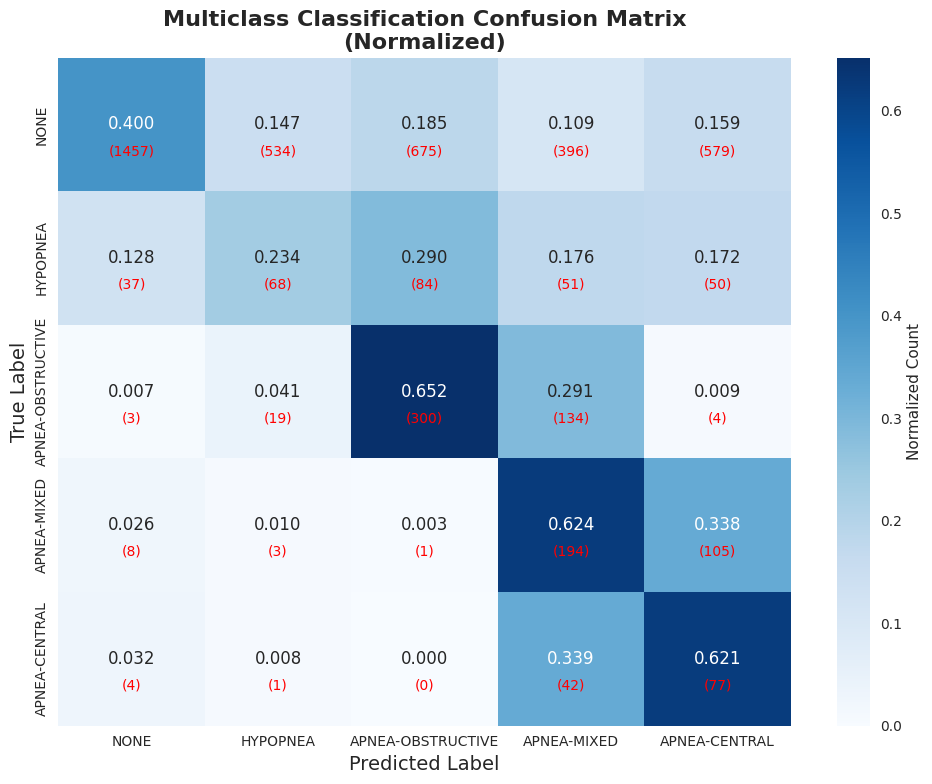

In [11]:
def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], title: str = "Confusion Matrix"):
    """
    Plot confusion matrix with nice formatting.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        title: Plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.3f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count'})
    
    plt.title(f'{title}\n(Normalized)', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    
    # Add raw counts as text
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j + 0.5, i + 0.7, f'({cm[i, j]})', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.show()


# Plot confusion matrices
if TASK == 'multitask':
    plot_confusion_matrix(
        binary_metrics['confusion_matrix'], 
        binary_class_names, 
        "Binary Classification Confusion Matrix"
    )
    
    plot_confusion_matrix(
        multiclass_metrics['confusion_matrix'], 
        multiclass_class_names, 
        "Multiclass Classification Confusion Matrix"
    )
    
else:
    plot_confusion_matrix(
        metrics['confusion_matrix'], 
        class_names, 
        f"{TASK.title()} Classification Confusion Matrix"
    )

## Visualization: Class Distribution and Predictions

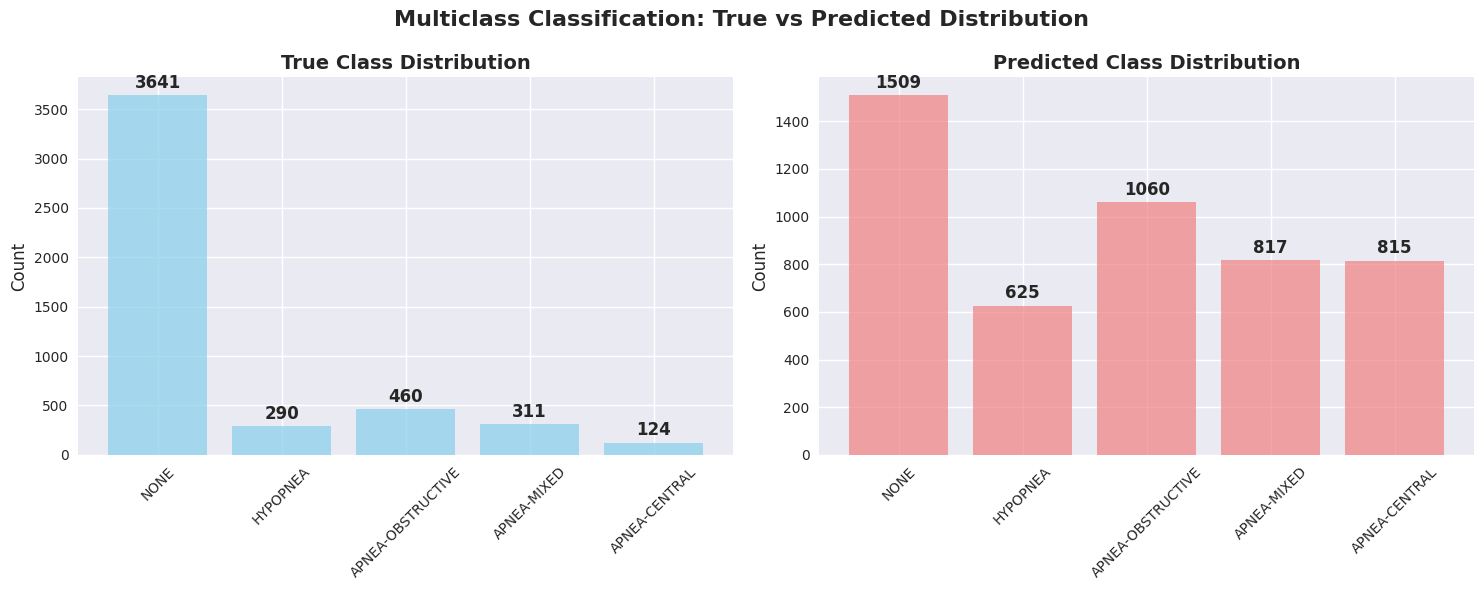

In [12]:
def plot_class_distribution_comparison(targets: np.ndarray, predictions: np.ndarray, 
                                     class_names: List[str], title: str = "Class Distribution"):
    """
    Plot comparison of true vs predicted class distributions.
    
    Args:
        targets: True labels
        predictions: Predicted labels
        class_names: List of class names
        title: Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # True distribution
    true_counts = np.bincount(targets, minlength=len(class_names))
    ax1.bar(class_names, true_counts, alpha=0.7, color='skyblue')
    ax1.set_title('True Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for i, count in enumerate(true_counts):
        ax1.text(i, count + max(true_counts) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')
    
    # Predicted distribution
    pred_counts = np.bincount(predictions, minlength=len(class_names))
    ax2.bar(class_names, pred_counts, alpha=0.7, color='lightcoral')
    ax2.set_title('Predicted Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for i, count in enumerate(pred_counts):
        ax2.text(i, count + max(pred_counts) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot class distributions
if TASK == 'multitask':
    plot_class_distribution_comparison(
        test_results['binary_targets'], 
        test_results['binary_predictions'], 
        binary_class_names, 
        "Binary Classification: True vs Predicted Distribution"
    )
    
    plot_class_distribution_comparison(
        test_results['multiclass_targets'], 
        test_results['multiclass_predictions'], 
        multiclass_class_names, 
        "Multiclass Classification: True vs Predicted Distribution"
    )
    
else:
    plot_class_distribution_comparison(
        targets, 
        predictions, 
        class_names, 
        f"{TASK.title()} Classification: True vs Predicted Distribution"
    )

## Visualization: Prediction Confidence Analysis

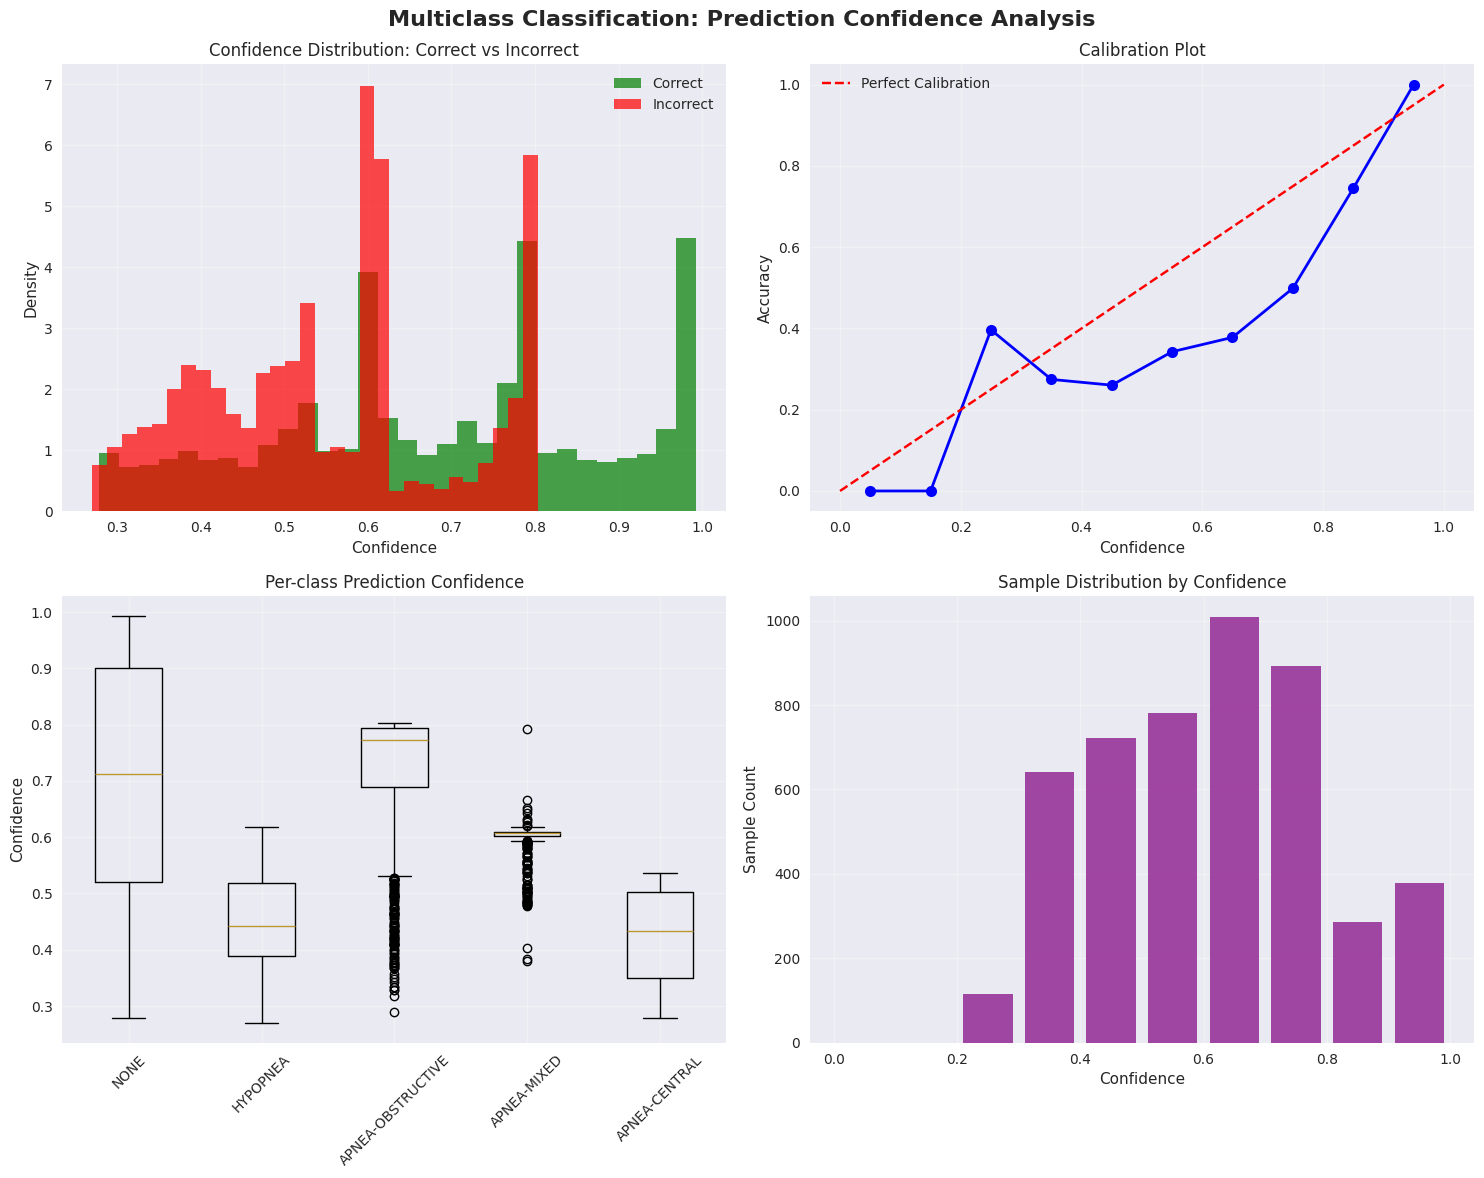


Confidence Analysis:
  Mean confidence (correct): 0.6840
  Mean confidence (incorrect): 0.5488
  Overall mean confidence: 0.6075
  Std confidence: 0.1837


In [13]:
def plot_prediction_confidence(logits: np.ndarray, targets: np.ndarray, predictions: np.ndarray,
                             class_names: List[str], title: str = "Prediction Confidence"):
    """
    Plot prediction confidence analysis.
    
    Args:
        logits: Model logits
        targets: True labels
        predictions: Predicted labels
        class_names: List of class names
        title: Plot title
    """
    # Convert logits to probabilities
    probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
    
    # Get confidence (max probability) for each prediction
    confidences = np.max(probabilities, axis=1)
    
    # Create correct/incorrect masks
    correct_mask = (targets == predictions)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confidence distribution for correct vs incorrect predictions
    axes[0, 0].hist(confidences[correct_mask], bins=30, alpha=0.7, 
                   label='Correct', color='green', density=True)
    axes[0, 0].hist(confidences[~correct_mask], bins=30, alpha=0.7, 
                   label='Incorrect', color='red', density=True)
    axes[0, 0].set_xlabel('Confidence')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Confidence Distribution: Correct vs Incorrect')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy vs confidence
    confidence_bins = np.linspace(0, 1, 11)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    bin_accuracies = []
    bin_counts = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i + 1])
        if np.sum(mask) > 0:
            accuracy = np.mean(correct_mask[mask])
            bin_accuracies.append(accuracy)
            bin_counts.append(np.sum(mask))
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)
    
    axes[0, 1].plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=8)
    axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
    axes[0, 1].set_xlabel('Confidence')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Calibration Plot')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Per-class confidence
    class_confidences = []
    for i in range(len(class_names)):
        class_mask = (predictions == i)
        if np.sum(class_mask) > 0:
            class_confidences.append(confidences[class_mask])
        else:
            class_confidences.append([0])
    
    axes[1, 0].boxplot(class_confidences, labels=class_names)
    axes[1, 0].set_ylabel('Confidence')
    axes[1, 0].set_title('Per-class Prediction Confidence')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Confidence vs sample count
    axes[1, 1].bar(bin_centers, bin_counts, width=0.08, alpha=0.7, color='purple')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Sample Count')
    axes[1, 1].set_title('Sample Distribution by Confidence')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nConfidence Analysis:")
    print(f"  Mean confidence (correct): {np.mean(confidences[correct_mask]):.4f}")
    print(f"  Mean confidence (incorrect): {np.mean(confidences[~correct_mask]):.4f}")
    print(f"  Overall mean confidence: {np.mean(confidences):.4f}")
    print(f"  Std confidence: {np.std(confidences):.4f}")


# Plot confidence analysis
if TASK == 'multitask':
    plot_prediction_confidence(
        test_results['binary_logits'], 
        test_results['binary_targets'], 
        test_results['binary_predictions'],
        binary_class_names, 
        "Binary Classification: Prediction Confidence Analysis"
    )
    
    plot_prediction_confidence(
        test_results['multiclass_logits'], 
        test_results['multiclass_targets'], 
        test_results['multiclass_predictions'],
        multiclass_class_names, 
        "Multiclass Classification: Prediction Confidence Analysis"
    )
    
else:
    plot_prediction_confidence(
        test_results['logits'], 
        targets, 
        predictions,
        class_names, 
        f"{TASK.title()} Classification: Prediction Confidence Analysis"
    )

## Per-Patient Analysis

Performing per-patient analysis...


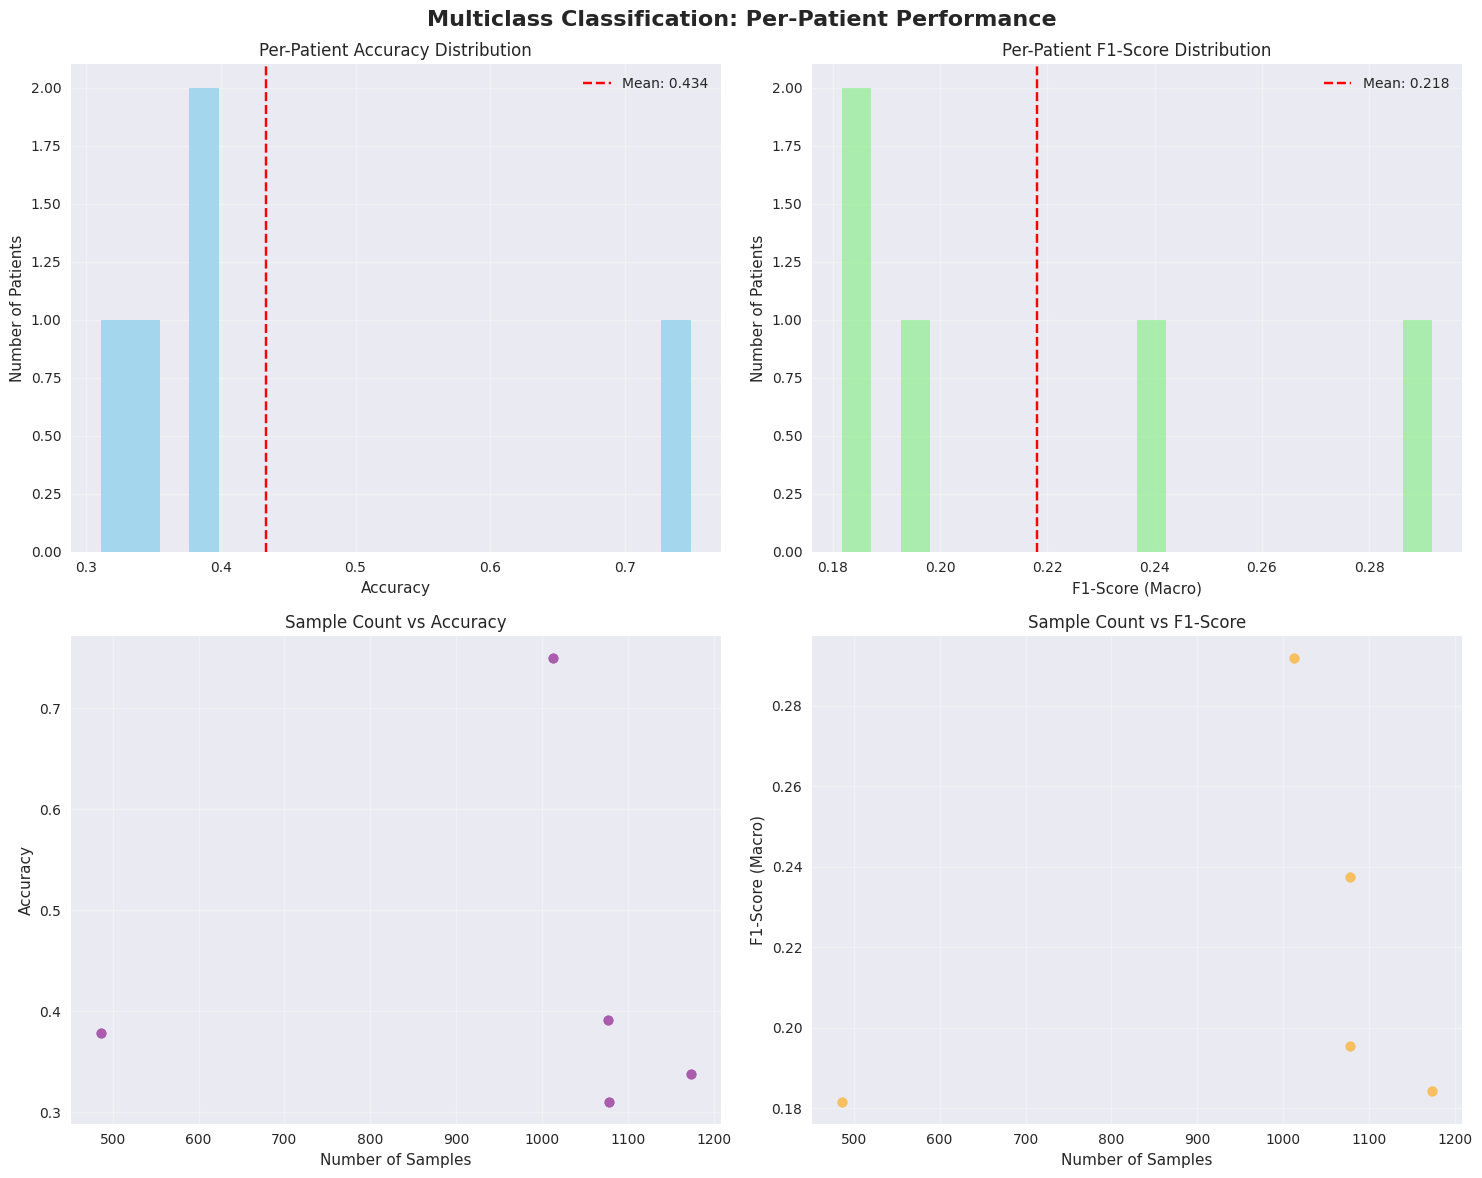


Per-Patient Performance Summary:
  Number of patients: 5
  Mean accuracy: 0.4337 ± 0.1792
  Mean F1-score: 0.2181 ± 0.0468
  Median accuracy: 0.3786
  Median F1-score: 0.1954

Best performing patients (by F1-score):
  Patient 11: Accuracy=0.749, F1=0.292, Samples=1012
  Patient 16: Accuracy=0.392, F1=0.237, Samples=1077
  Patient 26: Accuracy=0.311, F1=0.195, Samples=1078

Worst performing patients (by F1-score):
  Patient 6: Accuracy=0.379, F1=0.182, Samples=486
  Patient 20: Accuracy=0.338, F1=0.184, Samples=1173
  Patient 26: Accuracy=0.311, F1=0.195, Samples=1078


In [14]:
def analyze_per_patient_performance(dataset: OSASDataset, predictions: np.ndarray, 
                                  targets: np.ndarray, test_patients: List[int],
                                  class_names: List[str], title: str = "Per-Patient Performance"):
    """
    Analyze model performance per patient.
    
    Args:
        dataset: Test dataset
        predictions: Model predictions
        targets: True labels
        test_patients: List of test patient IDs
        class_names: List of class names
        title: Analysis title
    """
    patient_performances = []
    
    # Get patient information for each sample
    sample_patients = [window['patient'] for window in dataset.windows]
    
    for patient_id in test_patients:
        # Find samples for this patient
        patient_mask = np.array(sample_patients) == patient_id
        
        if np.sum(patient_mask) > 0:
            patient_targets = targets[patient_mask]
            patient_predictions = predictions[patient_mask]
            
            # Calculate metrics for this patient
            accuracy = accuracy_score(patient_targets, patient_predictions)
            f1_macro = f1_score(patient_targets, patient_predictions, average='macro', zero_division=0)
            
            patient_performances.append({
                'patient_id': patient_id,
                'n_samples': np.sum(patient_mask),
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'targets': patient_targets,
                'predictions': patient_predictions
            })
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(patient_performances)
    
    # Plot patient performance distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy distribution
    axes[0, 0].hist(df['accuracy'], bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].axvline(df['accuracy'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["accuracy"].mean():.3f}')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_ylabel('Number of Patients')
    axes[0, 0].set_title('Per-Patient Accuracy Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1 distribution
    axes[0, 1].hist(df['f1_macro'], bins=20, alpha=0.7, color='lightgreen')
    axes[0, 1].axvline(df['f1_macro'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["f1_macro"].mean():.3f}')
    axes[0, 1].set_xlabel('F1-Score (Macro)')
    axes[0, 1].set_ylabel('Number of Patients')
    axes[0, 1].set_title('Per-Patient F1-Score Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Sample count vs accuracy
    axes[1, 0].scatter(df['n_samples'], df['accuracy'], alpha=0.6, color='purple')
    axes[1, 0].set_xlabel('Number of Samples')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Sample Count vs Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Sample count vs F1
    axes[1, 1].scatter(df['n_samples'], df['f1_macro'], alpha=0.6, color='orange')
    axes[1, 1].set_xlabel('Number of Samples')
    axes[1, 1].set_ylabel('F1-Score (Macro)')
    axes[1, 1].set_title('Sample Count vs F1-Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nPer-Patient Performance Summary:")
    print(f"  Number of patients: {len(df)}")
    print(f"  Mean accuracy: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}")
    print(f"  Mean F1-score: {df['f1_macro'].mean():.4f} ± {df['f1_macro'].std():.4f}")
    print(f"  Median accuracy: {df['accuracy'].median():.4f}")
    print(f"  Median F1-score: {df['f1_macro'].median():.4f}")
    
    # Show best and worst performing patients
    print(f"\nBest performing patients (by F1-score):")
    best_patients = df.nlargest(3, 'f1_macro')
    for _, row in best_patients.iterrows():
        print(f"  Patient {row['patient_id']}: Accuracy={row['accuracy']:.3f}, F1={row['f1_macro']:.3f}, Samples={row['n_samples']}")
    
    print(f"\nWorst performing patients (by F1-score):")
    worst_patients = df.nsmallest(3, 'f1_macro')
    for _, row in worst_patients.iterrows():
        print(f"  Patient {row['patient_id']}: Accuracy={row['accuracy']:.3f}, F1={row['f1_macro']:.3f}, Samples={row['n_samples']}")


# Perform per-patient analysis
print("Performing per-patient analysis...")

if TASK == 'multitask':
    analyze_per_patient_performance(
        test_dataset, 
        test_results['binary_predictions'], 
        test_results['binary_targets'], 
        test_patients,
        binary_class_names, 
        "Binary Classification: Per-Patient Performance"
    )
    
    analyze_per_patient_performance(
        test_dataset, 
        test_results['multiclass_predictions'], 
        test_results['multiclass_targets'], 
        test_patients,
        multiclass_class_names, 
        "Multiclass Classification: Per-Patient Performance"
    )
    
else:
    analyze_per_patient_performance(
        test_dataset, 
        predictions, 
        targets, 
        test_patients,
        class_names, 
        f"{TASK.title()} Classification: Per-Patient Performance"
    )

## Summary and Recommendations

In [15]:
# Generate summary report
print("=" * 80)
print("EVALUATION SUMMARY REPORT")
print("=" * 80)
print(f"Task: {TASK.upper()}")
print(f"Test set size: {len(targets) if TASK != 'multitask' else len(test_results['binary_targets'])} samples")
print(f"Number of test patients: {len(test_patients)}")
print(f"Model loaded from checkpoint: {'Yes' if model_loaded else 'No (using random weights)'}")

if TASK == 'multitask':
    print(f"\nBinary Classification Performance:")
    print(f"  - Accuracy: {binary_metrics['accuracy']:.4f}")
    print(f"  - F1-Score (Macro): {binary_metrics['f1_macro']:.4f}")
    print(f"  - F1-Score (Weighted): {binary_metrics['f1_weighted']:.4f}")
    
    print(f"\nMulticlass Classification Performance:")
    print(f"  - Accuracy: {multiclass_metrics['accuracy']:.4f}")
    print(f"  - F1-Score (Macro): {multiclass_metrics['f1_macro']:.4f}")
    print(f"  - F1-Score (Weighted): {multiclass_metrics['f1_weighted']:.4f}")
    
else:
    print(f"\nOverall Performance:")
    print(f"  - Accuracy: {metrics['accuracy']:.4f}")
    print(f"  - F1-Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"  - F1-Score (Weighted): {metrics['f1_weighted']:.4f}")

print(f"\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

if not model_loaded:
    print("⚠️  WARNING: Evaluation performed with random weights!")
    print("   - Train a model using train_model.py first")
    print("   - Current results are not meaningful")
    
else:
    if TASK == 'binary':
        if metrics['accuracy'] > 0.8:
            print("✅ Model shows good performance for binary classification")
        elif metrics['accuracy'] > 0.6:
            print("⚠️  Model shows moderate performance - consider:")
            print("   - Hyperparameter tuning")
            print("   - Data augmentation")
            print("   - Class balancing techniques")
        else:
            print("❌ Model shows poor performance - consider:")
            print("   - Checking data preprocessing")
            print("   - Reviewing model architecture")
            print("   - Training for more epochs")
            
    elif TASK == 'multiclass':
        if metrics['f1_macro'] > 0.6:
            print("✅ Model shows good performance for multiclass classification")
        elif metrics['f1_macro'] > 0.3:
            print("⚠️  Model shows moderate performance - consider:")
            print("   - Class-specific data augmentation")
            print("   - Focal loss for imbalanced classes")
            print("   - Ensemble methods")
        else:
            print("❌ Model shows poor performance - consider:")
            print("   - Simplifying to binary classification first")
            print("   - Addressing severe class imbalance")
            print("   - Feature engineering")

print(f"\nGeneral recommendations:")
print(f"- Monitor per-patient performance variability")
print(f"- Consider patient-specific fine-tuning for outliers")
print(f"- Validate on external datasets when available")
print(f"- Implement confidence-based rejection for uncertain predictions")

print(f"\n" + "=" * 80)
print("EVALUATION COMPLETED")
print("=" * 80)

EVALUATION SUMMARY REPORT
Task: MULTICLASS
Test set size: 4826 samples
Number of test patients: 5
Model loaded from checkpoint: Yes

Overall Performance:
  - Accuracy: 0.4343
  - F1-Score (Macro): 0.3234
  - F1-Score (Weighted): 0.4998

RECOMMENDATIONS
⚠️  Model shows moderate performance - consider:
   - Class-specific data augmentation
   - Focal loss for imbalanced classes
   - Ensemble methods

General recommendations:
- Monitor per-patient performance variability
- Consider patient-specific fine-tuning for outliers
- Validate on external datasets when available
- Implement confidence-based rejection for uncertain predictions

EVALUATION COMPLETED
